# Capstone: Topic Modelling on AMD vs Nvidia GPU

## Contents
- Data Extraction
- Data Cleaning
- [EDA](#EDA)
- [Prepare data for LDA Analysis](#Prepare-data-for-LDA-Analysis)
- [LDA Model Training](#LDA-Model-Training)
- Model creation
- Model Evaluation

In [1]:
# Common imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pprint import pprint
import os

import re
# NLTK Library
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Import PRAW package
import praw
from praw.models import MoreComments

# Gensim library
import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora

import pyLDAvis.gensim
import pickle 
import pyLDAvis

# Detect non-english words
from langdetect import detect, DetectorFactory
DetectorFactory.seed = 0

# Detect non-english words using spacy
import spacy
from spacy_langdetect import LanguageDetector
nlp = spacy.load("en_core_web_sm")
nlp.add_pipe(LanguageDetector(), name='language_detector', last=True)


# Import the wordcloud library
from wordcloud import WordCloud

%matplotlib inline

In [2]:
# Set the max rows and columns for Pandas
pd.options.display.max_columns = 100
pd.options.display.max_rows = 200

In [3]:
# Set the style use
plt.style.use('ggplot')

## Create a helper function to scrap the dataset in reddit

In [4]:
# Create a dictionary with keys as the text and the value being reddit submission id 
nvidia_gpu_sub_dict = {'rtx_3060ti': 'k4mctp', 'rtx_3070':'jj8k0l', 
                       'rtx_3080': 'itw87x', 'rtx_3090': 'iyy5sx', 'rtx_3000': 'iko4ir'}
amd_gpu_sub_dict = {'amd_gpu': 'iknr7g', 'rx_6000_rdna2':'jjq6v1', 'rx_6000_nov_18':'jvxm8z', 'radeon_rx_6000':'jwesyt'} 

In [5]:
# Additional nvidia comments scrapped
add_nvidia_gpu_sub_dict = {'rtx_3090vs3080vs3070': 'ioyjk6', 'scalper_warning': 'ivi4qm', 'rtx_3090_memory': 'igw0bg',
                          'rtx_3080ti_priced': 'jrmtmx', 'rtx_3080_3090_leak': 'ii6179'}

In [6]:
 reddit = praw.Reddit(
     client_id="IR7Y4cUBrVAbGg",
     client_secret="podr43kzztn_CoVgtNQiNpDfjI5mjg",
     user_agent="gpu_scrapper_32",
     username="leader2345",
     password="rPLHgrS8"
 )

In [7]:
def scrapeGPUComment(gpu_dict):
    for key, value in gpu_dict.items():
        # Creates the GPU list to hold the reddit comments
        gpu_lst = []
        # Creating the submission object for rtx megathreads
        submission = reddit.submission(id=value)
        
        # Extract all the commments
        submission.comments.replace_more(limit=None)
        for comment in submission.comments.list():
            gpu_lst.append(comment.body)
        # Converted to Dataframe format
        rtx_df = pd.DataFrame({'Reddit comments':gpu_lst})
        # Creating the column for tags, the keys of the dictionary will be stored here
        rtx_df['tag'] = key
        # Export the individual submissions to csv file
        rtx_df.to_csv('./reddit dataset/' + key + '.csv', index=False)

In [ ]:
# Scrapping of nvidia commments
# scrapeGPUComment(nvidia_gpu_sub_dict)

In [ ]:
# Scrapping of amd commments
# scrapeGPUComment(amd_gpu_sub_dict)

In [ ]:
# Scrapping of additional nvidia commments
# scrapeGPUComment(add_nvidia_gpu_sub_dict)

In [8]:
# Read in the dataframes

# Nvidia's comments
rtx_3000 = pd.read_csv('./reddit dataset/rtx_3000.csv')
rtx_3060ti = pd.read_csv('./reddit dataset/rtx_3060ti.csv')
rtx_3070 = pd.read_csv('./reddit dataset/rtx_3070.csv')
rtx_3080 = pd.read_csv('./reddit dataset/rtx_3080.csv')
rtx_3090 = pd.read_csv('./reddit dataset/rtx_3090.csv')

# Amd's comments
amd_gpu = pd.read_csv('./reddit dataset/amd_gpu.csv')
rx_6000 = pd.read_csv('./reddit dataset/radeon_rx_6000.csv')
rx_6000_nov_18 = pd.read_csv('./reddit dataset/rx_6000_nov_18.csv')
rx_6000_rdna2 = pd.read_csv('./reddit dataset/rx_6000_rdna2.csv')

# Additional Nvidia's comments scrapped
rtx_3090vs3080vs3070 = pd.read_csv('./reddit dataset/rtx_3090vs3080vs3070.csv')
scalper_warning = pd.read_csv('./reddit dataset/scalper_warning.csv')
rtx_3090_memory = pd.read_csv('./reddit dataset/rtx_3090_memory.csv')
rtx_3080ti_priced = pd.read_csv('./reddit dataset/rtx_3080ti_priced.csv')
rtx_3080_3090_leak = pd.read_csv('./reddit dataset/rtx_3080_3090_leak.csv')

In [9]:
# Concat the dataframes by their rows
combined_df = pd.concat([rtx_3000, rtx_3060ti, rtx_3070, rtx_3080,
                        rtx_3090, amd_gpu, rx_6000, rx_6000_nov_18, rx_6000_rdna2,
                        rtx_3090vs3080vs3070, scalper_warning, rtx_3090_memory, rtx_3080ti_priced, rtx_3080_3090_leak],
                       axis=0, ignore_index = False)

# Data cleaning

## Removing the null values

In [10]:
# Check the dimensions of the data
combined_df.shape

(34534, 2)

In [11]:
# Checking for null values
combined_df.isnull().sum()

Reddit comments    3
tag                0
dtype: int64

In [12]:
# Check for null values
combined_df.dropna(inplace = True)

In [13]:
# Checking for null values
combined_df.isnull().sum()

Reddit comments    0
tag                0
dtype: int64

## Dropping comments with `[deleted]` and `[removed]` in them

In [14]:
combined_df.shape

(34531, 2)

In [15]:
removed_deleted_comments_idx = combined_df[(combined_df['Reddit comments'] == '[removed]') | (combined_df['Reddit comments'] == '[deleted]')].index
removed_deleted_comments_idx

Int64Index([  46,   56,   57,   82,   83,  118,  150,  157,  160,  244,
            ...
            2240, 2321, 2343, 2348, 2350, 2364, 2407, 2422, 2425, 2436],
           dtype='int64', length=778)

A total of 778 comments will be dropped from the dataframe.

In [16]:
# Drop the deleted and removed comments
combined_df.drop(removed_deleted_comments_idx, axis=0, inplace = True)

In [17]:
combined_df.shape

(28809, 2)

## Cleaning the Reddit comments

In [18]:
# Full function to clean the title and the post
def clean_post(df):
    """
    This function removes the unnecessary characters, punctuations, removes stop words and lemmantizes the words
    from the posts and titles. Lemmantization is used as I want to preserve the meaning of the words in which it'll compare the words against a dictionary.
    """
    new_lst = []
    
    # Stop words
    stops = stopwords.words('english')
    # Adding additional stop words
    stops.extend(['http', 'www'])
    # stops.extend(['nvidia', 'amd', 'card', 'gpu', 'http', 'www'])
    stops = set(stops)
    
    # Lemmatizer
    lemmatizer = WordNetLemmatizer()
    
    for post in df:
        # Lowercase the text
        post = post.lower()

        # Find the https websites and removes them
        post = re.sub(r'\(https:.*?\)','',post)

        # Removes youtube links
        post = re.sub('https:.*?\\n','',post)

        # Removes uncaptured url links at the bottom of the text
        post = re.sub('https.*?[\\n|"]','',post)

        # Removes characters: \n\n&amp;#x200B;
        post = re.sub('\\n\\n&amp;#x200b;\\n\\n','',post)

        # Removing the special characters, like punctuation marks, periods
        post = re.sub(r'[^\w]',' ',post)
        
        # Removes digits and keeps the letters
        # post = re.sub(r'[^a-zA-Z]', ' ', post)

        # Removes underscores
        post = re.sub(' _', ' ',post)

        # Removes addtional white spaces
        post = re.sub(' +', ' ',post)
        
        # Stores the words in a list 
        lst = [lemmatizer.lemmatize(word) for word in post.split() if word not in stops]
            
        new_lst.append(" ".join(lst))
        
    return new_lst

In [19]:
# Cleans the Reddit comments column
combined_df['Reddit comments'] = clean_post(combined_df['Reddit comments'])
combined_df['Reddit comments']

0                     pre order time releasing 17th seems
2                          going hard grab card 3080 17th
4       uk price 3090 1399 3080 649 3070 469 scan aib ...
5       badly want 3080 especially price still concern...
6       nobody talking many spatula jensen whole pot full
                              ...                        
2433             even motherboard say pcie 3 0 compatible
2434    thanks understanding know course none 3000s dv...
2435                                         buy 1400 gpu
2437                          lol know ill wait 3070 3060
2438    generational compatibility either also compati...
Name: Reddit comments, Length: 28809, dtype: object

## Dropping comments that are empty

In [20]:
combined_df.describe()

,Reddit comments,tag
count,28809,28809
unique,27985,14
top,,rx_6000_rdna2
freq,150,9869


In [21]:
(combined_df['Reddit comments'] == '').sum()

150

There are 150 empty comments that have to be dropped.

In [22]:
empty_comments_idx = combined_df[combined_df['Reddit comments'] == ''].index
combined_df.drop(empty_comments_idx, axis=0, inplace=True)

In [23]:
(combined_df['Reddit comments'] == '').sum()

0

The empty comments have been removed.

## Setting the tags with either `Nvidia` or `Amd`

In [24]:
combined_df['tag'].unique()

array(['rtx_3000', 'rtx_3060ti', 'rtx_3070', 'rtx_3080', 'rtx_3090',
       'amd_gpu', 'radeon_rx_6000', 'rx_6000_nov_18', 'rx_6000_rdna2',
       'rtx_3090vs3080vs3070', 'scalper_warning', 'rtx_3090_memory',
       'rtx_3080ti_priced', 'rtx_3080_3090_leak'], dtype=object)

These tags need to be renamed to either `Nvidia` or `Amd`

In [25]:
nvidia_tag_lst = list(nvidia_gpu_sub_dict) + list(add_nvidia_gpu_sub_dict)
amd_tag_lst = list(amd_gpu_sub_dict)

In [26]:
print(nvidia_tag_lst)
print(amd_tag_lst)

['rtx_3060ti', 'rtx_3070', 'rtx_3080', 'rtx_3090', 'rtx_3000', 'rtx_3090vs3080vs3070', 'scalper_warning', 'rtx_3090_memory', 'rtx_3080ti_priced', 'rtx_3080_3090_leak']
['amd_gpu', 'rx_6000_rdna2', 'rx_6000_nov_18', 'radeon_rx_6000']


In [27]:
combined_df['tag'].replace(nvidia_tag_lst, ['nvidia' for _ in range(len(nvidia_tag_lst))], inplace = True)
combined_df['tag'].replace(amd_tag_lst, ['amd' for _ in range(len(amd_tag_lst))], inplace = True)

In [28]:
combined_df['tag'].value_counts()

amd       15837
nvidia    12085
Name: tag, dtype: int64

## Removing duplicates in the dataframe

In [29]:
combined_df.duplicated(subset='Reddit comments', keep = False).sum()

919

In [30]:
combined_df[combined_df.duplicated(subset='Reddit comments', keep = False)]

,Reddit comments,tag
58,pre order,nvidia
130,pre order,nvidia
159,http evga com article 01434 evga geforce rtx 3...,nvidia
408,scared new mining performance card new memory ...,nvidia
450,3060,nvidia
...,...,...
2131,case,nvidia
2143,one,nvidia
2261,think,nvidia
2405,good bot,nvidia


There are 941 comments that are duplicated and have to be dropped.

In [31]:
combined_df.shape

(27922, 2)

In [32]:
combined_df.drop_duplicates(subset='Reddit comments', keep = False, ignore_index= True, inplace = True)

In [33]:
combined_df.shape

(27003, 2)

In [34]:
combined_df.duplicated(subset='Reddit comments', keep = False).sum()

0

The duplicated comments have been removed.

In [37]:
# Randomly going through the rows to check if it's cleaned properly 
combined_df['Reddit comments'].loc[np.random.randint(1707)]

'rip rdna 2'

### Removing non-english words in the reviews (Possible to ignore)

In [ ]:
# Removing non english by creating a helper function
from langdetect import detect
def isenglish(text):
    try:
        if nlp(text)._.language.get('language') == 'en':
            return 1
        else:
            return 0
    except:
        return 0

In [ ]:
GPU_df['isenglish'] = GPU_df['Customer Review'].apply(isenglish)

In [ ]:
GPU_df[GPU_df.loc[:,'isenglish'] == 0][['Customer Review']].head(10)

In [ ]:
# Count number of rows with the string deleted in them
GPU_df['Customer Review'].map(lambda x: x.count('deleted')).sum()

In [ ]:
GPU_df[GPU_df.loc[:,'isenglish'] == 0][['Customer Review']].count()

A total of 130 rows were non-english reviews. These have to be removed.

## Exporting the cleaned csv file 

In [38]:
# Save to csv file
combined_df.to_csv('./reddit dataset/cleaned_combined_df.csv', index=False)

# EDA on the comments

In [39]:
# Read the existing csv file
GPU_df = pd.read_csv('./reddit dataset/cleaned_combined_df.csv')
GPU_df

,Reddit comments,tag
0,pre order time releasing 17th seems,nvidia
1,going hard grab card 3080 17th,nvidia
2,uk price 3090 1399 3080 649 3070 469 scan aib ...,nvidia
3,badly want 3080 especially price still concern...,nvidia
4,nobody talking many spatula jensen whole pot full,nvidia
...,...,...
26998,even motherboard say pcie 3 0 compatible,nvidia
26999,thanks understanding know course none 3000s dv...,nvidia
27000,buy 1400 gpu,nvidia
27001,lol know ill wait 3070 3060,nvidia


In [40]:
GPU_df.describe()

,Reddit comments,tag
count,27003,27003
unique,27003,2
top,lowering 3080,amd
freq,1,15188


In [41]:
GPU_df.shape

(27003, 2)

In [42]:
# Check for null values
GPU_df.isnull().sum()

Reddit comments    0
tag                0
dtype: int64

In [43]:
# Checking for duplicated comments
GPU_df.duplicated(subset='Reddit comments', keep=False).sum()

0

## Distribution of AMD and Nvidia comments

In [44]:
GPU_df['tag'].value_counts(normalize=True) * 100

amd       56.245602
nvidia    43.754398
Name: tag, dtype: float64

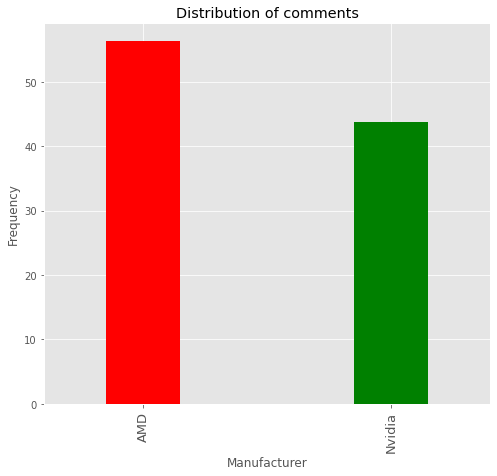

In [59]:
(GPU_df['tag'].value_counts(normalize=True) * 100).plot(kind='bar', 
                                                        title='Distribution of comments',
                                                        figsize=(8,7),
                                                        xlabel = 'Manufacturer',
                                                       ylabel='Frequency',
                                                       color = ['red','green'],
                                                       width=0.3)

plt.xticks(np.arange(2), ['AMD', 'Nvidia'],fontsize=13);

In the dataset, around 56% of the comments were from AMD and the Hardware subreddit and 43% of the comments were from Nvidia's subreddit.

## EDA on Amd comments

In [75]:
# Obtaining only AMD comments
amd_df = GPU_df[GPU_df['tag'] == 'amd']
amd_df

,Reddit comments,tag
5008,sound like samsung 8nm cheap,amd
5009,might ethic mongol invasion tech really someth...,amd
5010,nvidia software ai learning big selling point,amd
5011,ultimate countdown marketing campaign nvidia b...,amd
5012,excited amd guy compete going go nvidia brand ...,amd
...,...,...
20191,dude really understand example confused get sa...,amd
20192,still know example like still thought looked,amd
20193,probably score higher english proficiency test...,amd
20194,prove know concept cost opportunity efficiency...,amd


In [83]:
# Obtain the length of of each post and store the values in length
textlength = amd_df['Reddit comments'].apply(lambda x:len(x.split())).rename('textlength')
textlength

5008      5
5009      8
5010      7
5011     11
5012     10
         ..
20191    11
20192     7
20193    11
20194    12
20195    20
Name: textlength, Length: 15188, dtype: int64

In [85]:
amd_df = pd.concat([amd_df, textlength], axis=1)
amd_df

,Reddit comments,tag,textlength
5008,sound like samsung 8nm cheap,amd,5
5009,might ethic mongol invasion tech really someth...,amd,8
5010,nvidia software ai learning big selling point,amd,7
5011,ultimate countdown marketing campaign nvidia b...,amd,11
5012,excited amd guy compete going go nvidia brand ...,amd,10
...,...,...,...
20191,dude really understand example confused get sa...,amd,11
20192,still know example like still thought looked,amd,7
20193,probably score higher english proficiency test...,amd,11
20194,prove know concept cost opportunity efficiency...,amd,12


(0.0, 110.0)

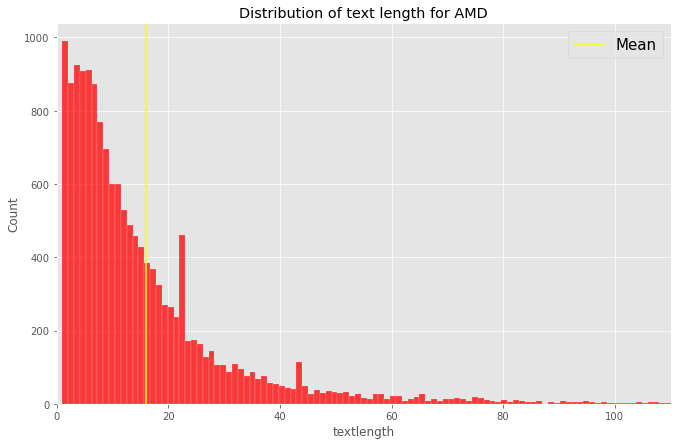

In [102]:
# Plotting the histogram of the textlength
plt.figure(figsize=(11,7))
sns.histplot(amd_df['textlength'], color='red')

plt.title('Distribution of text length for AMD')
# Plot the mean of the distribution
plt.axvline(amd_df['textlength'].mean(), color='yellow')
plt.legend(['Mean'], fontsize=15)
plt.xlim(0,110)

## EDA on Nvidia comments

## 

### EDA on Customer Review Title

In [ ]:
customer_review_title = " ".join(GPU_df['Customer Review Title'])

In [ ]:
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, 
                      contour_width=5, contour_color='steelblue', width=700, height=500)
wordcloud.generate(customer_review_title)
# Visualize the word cloud
wordcloud.to_image()

Based on the word cloud, it seems that consumers are mostly satisfied with their GPU purchase with 'good', 'great' and 'best' words coming out at the top. The consumers are mostly gamers and most of them play in 1080p resolution and they seem to be price sensitive with the words such as 'bang buck' and 'great value' having a bigger size. 

In [ ]:
customer_review_title_list = customer_review_title.split()
customer_review_title_dict = {}

for word in customer_review_title_list:
    if word not in customer_review_title_dict.keys():
        customer_review_title_dict[word] = customer_review_title_list.count(word)
    else:
        continue
        
customer_review_title_dict

In [ ]:
df = {'words': customer_review_title_dict.keys(), 'freq': customer_review_title_dict.values()}
customer_review_title_df = pd.DataFrame(df)
customer_review_title_df.sort_values('freq', ascending=False).set_index('words').head(10).plot(kind='barh', figsize=(11,7),
                                                                                              title='Frequency of words in customer review title')
plt.xticks(fontsize=12)
plt.legend([]);

The graph shows consistency with the word cloud on the frequency of the words appearing in the customer review title.

In [ ]:
# customer_review_title_df['freq'].hist(bins=150)
# plt.xlim(0,50)

### EDA on Customer Review

In [ ]:
customer_review = " ".join(GPU_df['Customer Review'])

In [ ]:
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, 
                      contour_width=5, contour_color='steelblue', width=700, height=500)
wordcloud.generate(customer_review)
# Visualize the word cloud
wordcloud.to_image()

Similar to the customer review title word cloud, consumers who purchase GPUs tend to be gamers and they play on 1080p resolution. GPU fans are an important factor when making a GPU purchase as the word 'fan' size is rather big. The word 'issue' and 'problem' shows up big which suggests that consumers may have encountered issues with the GPUs they have purchased. The two brands 'amd' and 'nvidia' shows that these 2 are the major players in the GPU market. GPU drivers seem to play an important role in making sure that the GPU is functioning.

In [ ]:
customer_review_list = customer_review.split()
customer_review_dict = {}

for word in customer_review_list:
    if word not in customer_review_dict.keys():
        customer_review_dict[word] = customer_review_list.count(word)
    else:
        continue
        
customer_review_dict

In [ ]:
review_df = {'words': customer_review_dict.keys(), 'freq': customer_review_dict.values()}
customer_review_df = pd.DataFrame(review_df)
customer_review_df.sort_values('freq', ascending=False).set_index('words').head(10).plot(kind='barh', figsize=(11,7),
                                                                                              title='Frequency of words in customer review title')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend([]);

The graph shows consistency with the word cloud on the frequency of the words appearing in the customer review title.

## Prepare data for LDA Analysis

I'll be using only Customer Review to conduct the LDA Analysis as it makes up the bulk of the words.

In [ ]:
# Converting to the customer reviews from series to a list.
data = GPU_df['Customer Review'].values.tolist()
data[600]

In [ ]:
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(sentence))

In [ ]:
texts = list(sent_to_words(data))

In [ ]:
# Prints the first document with up to 30 words in them
print(texts[:1][0][:30])

In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(texts)

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

## LDA Model Training

In [ ]:
# number of topics
num_topics = 10

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics,
                                      passes=20, random_state=42)

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join(os.getcwd()+'\\visualization\\'+'ldavis_prepared_'+str(num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if False:
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, os.getcwd()+ '\\visualization\\' + 'ldavis_prepared_'+ str(num_topics) +'.html')
LDAvis_prepared

# Others